In [1]:
# Predefined mapping dictionary (1-based hint strengths).
ACTION_MAP = {
  "Focus": {
    "Seek Next Step": {
      "1": 0,
      "2": 1,
      "3": 2,
      "4": 3,
      "5": 4
    },
    "Confirm Calculation": {
      "1": 5,
      "2": 6,
      "3": 7,
      "4": 8,
      "5": 9
    },
    "Re-direct to Sub-Problem": {
      "1": 10,
      "2": 11,
      "3": 12,
      "4": 13,
      "5": 14
    },
    "Highlight Missing Info": {
      "1": 15,
      "2": 16,
      "3": 17,
      "4": 18,
      "5": 19
    }
  },
  "Probing": {
    "Ask for Explanation": {
      "1": 20,
      "2": 21,
      "3": 22,
      "4": 23,
      "5": 24
    },
    "Seek Self-Correction": {
      "1": 25,
      "2": 26,
      "3": 27,
      "4": 28,
      "5": 29
    },
    "Hypothetical Variation": {
      "1": 30,
      "2": 31,
      "3": 32,
      "4": 33,
      "5": 34
    },
    "Check Understanding/Concept": {
      "1": 35,
      "2": 36,
      "3": 37,
      "4": 38,
      "5": 39
    },
    "Encourage Comparison": {
      "1": 40,
      "2": 41,
      "3": 42,
      "4": 43,
      "5": 44
    }
  },
  "Telling": {
    "Partial Reveal (Strategy)": {
      "1": 45,
      "2": 46,
      "3": 47,
      "4": 48,
      "5": 49
    },
    "Full Reveal (Answer)": {
      "1": 50,
      "2": 51,
      "3": 52,
      "4": 53,
      "5": 54
    },
    "Corrective Explanation": {
      "1": 55,
      "2": 56,
      "3": 57,
      "4": 58,
      "5": 59
    }
  },
  "Generic": {
    "Greeting/Farewell": {
      "1": 60,
      "2": 61,
      "3": 62,
      "4": 63,
      "5": 64
    },
    "Acknowledgment/Praise": {
      "1": 65,
      "2": 66,
      "3": 67,
      "4": 68,
      "5": 69
    },
    "Summarize Progress": {
      "1": 70,
      "2": 71,
      "3": 72,
      "4": 73,
      "5": 74
    },
    "General Inquiry/Filler": {
      "1": 75,
      "2": 76,
      "3": 77,
      "4": 78,
      "5": 79
    }
  }
}

# for k1 in ACTION_MAP:
#     for k2 in ACTION_MAP[k1]:
#         for k3 in ACTION_MAP[k1][k2]:
#             print(ACTION_MAP[k1][k2][k3], ": \"", ", ".join([k1,k2,"Hint Strength " + k3]) ,"\"", ",", sep="")

ACTION_MAP_Flipped = {
    0: "Focus, Seek Next Step, Hint Strength 1",
    1: "Focus, Seek Next Step, Hint Strength 2",
    2: "Focus, Seek Next Step, Hint Strength 3",
    3: "Focus, Seek Next Step, Hint Strength 4",
    4: "Focus, Seek Next Step, Hint Strength 5",
    5: "Focus, Confirm Calculation, Hint Strength 1",
    6: "Focus, Confirm Calculation, Hint Strength 2",
    7: "Focus, Confirm Calculation, Hint Strength 3",
    8: "Focus, Confirm Calculation, Hint Strength 4",
    9: "Focus, Confirm Calculation, Hint Strength 5",
    10: "Focus, Re-direct to Sub-Problem, Hint Strength 1",
    11: "Focus, Re-direct to Sub-Problem, Hint Strength 2",
    12: "Focus, Re-direct to Sub-Problem, Hint Strength 3",
    13: "Focus, Re-direct to Sub-Problem, Hint Strength 4",
    14: "Focus, Re-direct to Sub-Problem, Hint Strength 5",
    15: "Focus, Highlight Missing Info, Hint Strength 1",
    16: "Focus, Highlight Missing Info, Hint Strength 2",
    17: "Focus, Highlight Missing Info, Hint Strength 3",
    18: "Focus, Highlight Missing Info, Hint Strength 4",
    19: "Focus, Highlight Missing Info, Hint Strength 5",
    20: "Probing, Ask for Explanation, Hint Strength 1",
    21: "Probing, Ask for Explanation, Hint Strength 2",
    22: "Probing, Ask for Explanation, Hint Strength 3",
    23: "Probing, Ask for Explanation, Hint Strength 4",
    24: "Probing, Ask for Explanation, Hint Strength 5",
    25: "Probing, Seek Self-Correction, Hint Strength 1",
    26: "Probing, Seek Self-Correction, Hint Strength 2",
    27: "Probing, Seek Self-Correction, Hint Strength 3",
    28: "Probing, Seek Self-Correction, Hint Strength 4",
    29: "Probing, Seek Self-Correction, Hint Strength 5",
    30: "Probing, Hypothetical Variation, Hint Strength 1",
    31: "Probing, Hypothetical Variation, Hint Strength 2",
    32: "Probing, Hypothetical Variation, Hint Strength 3",
    33: "Probing, Hypothetical Variation, Hint Strength 4",
    34: "Probing, Hypothetical Variation, Hint Strength 5",
    35: "Probing, Check Understanding/Concept, Hint Strength 1",
    36: "Probing, Check Understanding/Concept, Hint Strength 2",
    37: "Probing, Check Understanding/Concept, Hint Strength 3",
    38: "Probing, Check Understanding/Concept, Hint Strength 4",
    39: "Probing, Check Understanding/Concept, Hint Strength 5",
    40: "Probing, Encourage Comparison, Hint Strength 1",
    41: "Probing, Encourage Comparison, Hint Strength 2",
    42: "Probing, Encourage Comparison, Hint Strength 3",
    43: "Probing, Encourage Comparison, Hint Strength 4",
    44: "Probing, Encourage Comparison, Hint Strength 5",
    45: "Telling, Partial Reveal (Strategy), Hint Strength 1",
    46: "Telling, Partial Reveal (Strategy), Hint Strength 2",
    47: "Telling, Partial Reveal (Strategy), Hint Strength 3",
    48: "Telling, Partial Reveal (Strategy), Hint Strength 4",
    49: "Telling, Partial Reveal (Strategy), Hint Strength 5",
    50: "Telling, Full Reveal (Answer), Hint Strength 1",
    51: "Telling, Full Reveal (Answer), Hint Strength 2",
    52: "Telling, Full Reveal (Answer), Hint Strength 3",
    53: "Telling, Full Reveal (Answer), Hint Strength 4",
    54: "Telling, Full Reveal (Answer), Hint Strength 5",
    55: "Telling, Corrective Explanation, Hint Strength 1",
    56: "Telling, Corrective Explanation, Hint Strength 2",
    57: "Telling, Corrective Explanation, Hint Strength 3",
    58: "Telling, Corrective Explanation, Hint Strength 4",
    59: "Telling, Corrective Explanation, Hint Strength 5",
    60: "Generic, Greeting/Farewell, Hint Strength 1",
    61: "Generic, Greeting/Farewell, Hint Strength 2",
    62: "Generic, Greeting/Farewell, Hint Strength 3",
    63: "Generic, Greeting/Farewell, Hint Strength 4",
    64: "Generic, Greeting/Farewell, Hint Strength 5",
    65: "Generic, Acknowledgment/Praise, Hint Strength 1",
    66: "Generic, Acknowledgment/Praise, Hint Strength 2",
    67: "Generic, Acknowledgment/Praise, Hint Strength 3",
    68: "Generic, Acknowledgment/Praise, Hint Strength 4",
    69: "Generic, Acknowledgment/Praise, Hint Strength 5",
    70: "Generic, Summarize Progress, Hint Strength 1",
    71: "Generic, Summarize Progress, Hint Strength 2",
    72: "Generic, Summarize Progress, Hint Strength 3",
    73: "Generic, Summarize Progress, Hint Strength 4",
    74: "Generic, Summarize Progress, Hint Strength 5",
    75: "Generic, General Inquiry/Filler, Hint Strength 1",
    76: "Generic, General Inquiry/Filler, Hint Strength 2",
    77: "Generic, General Inquiry/Filler, Hint Strength 3",
    78: "Generic, General Inquiry/Filler, Hint Strength 4",
    79: "Generic, General Inquiry/Filler, Hint Strength 5",
}

ACTION_MAP_Flipped[79]

MAP_TOP_CATEGORY = {
    "Focus": 0,
    "Probing": 1,
    "Telling": 2,
    "Generic": 3,
}

# i = 0
# for k1 in ACTION_MAP:
#     print("\"", k1 ,"\"", ": ", i ,",", sep="")
#     i += 1

for k1 in ACTION_MAP:
    for k2 in ACTION_MAP[k1]:
        for k3 in ACTION_MAP[k1][k2]:
            print(ACTION_MAP[k1][k2][k3], ": ", MAP_TOP_CATEGORY[k1],  ",", sep="")


MAP_BACK = {
    0: 0,
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0,
    8: 0,
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 1,
    21: 1,
    22: 1,
    23: 1,
    24: 1,
    25: 1,
    26: 1,
    27: 1,
    28: 1,
    29: 1,
    30: 1,
    31: 1,
    32: 1,
    33: 1,
    34: 1,
    35: 1,
    36: 1,
    37: 1,
    38: 1,
    39: 1,
    40: 1,
    41: 1,
    42: 1,
    43: 1,
    44: 1,
    45: 2,
    46: 2,
    47: 2,
    48: 2,
    49: 2,
    50: 2,
    51: 2,
    52: 2,
    53: 2,
    54: 2,
    55: 2,
    56: 2,
    57: 2,
    58: 2,
    59: 2,
    60: 3,
    61: 3,
    62: 3,
    63: 3,
    64: 3,
    65: 3,
    66: 3,
    67: 3,
    68: 3,
    69: 3,
    70: 3,
    71: 3,
    72: 3,
    73: 3,
    74: 3,
    75: 3,
    76: 3,
    77: 3,
    78: 3,
    79: 3,
} 

0: 0,
1: 0,
2: 0,
3: 0,
4: 0,
5: 0,
6: 0,
7: 0,
8: 0,
9: 0,
10: 0,
11: 0,
12: 0,
13: 0,
14: 0,
15: 0,
16: 0,
17: 0,
18: 0,
19: 0,
20: 1,
21: 1,
22: 1,
23: 1,
24: 1,
25: 1,
26: 1,
27: 1,
28: 1,
29: 1,
30: 1,
31: 1,
32: 1,
33: 1,
34: 1,
35: 1,
36: 1,
37: 1,
38: 1,
39: 1,
40: 1,
41: 1,
42: 1,
43: 1,
44: 1,
45: 2,
46: 2,
47: 2,
48: 2,
49: 2,
50: 2,
51: 2,
52: 2,
53: 2,
54: 2,
55: 2,
56: 2,
57: 2,
58: 2,
59: 2,
60: 3,
61: 3,
62: 3,
63: 3,
64: 3,
65: 3,
66: 3,
67: 3,
68: 3,
69: 3,
70: 3,
71: 3,
72: 3,
73: 3,
74: 3,
75: 3,
76: 3,
77: 3,
78: 3,
79: 3,


Imitative Learning

In [75]:
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd

In [77]:
# data loading
dataset = pd.read_csv('dataset/FINAL_MATHDIAL.csv')

dataset = dataset.dropna(subset=['next_action_id'])
dataset["next_action_id"] = dataset["next_action_id"].astype("int32")

# back to 4 actions, 0...3, 
    # "Focus": 0,
    # "Probing": 1,
    # "Telling": 2,
    # "Generic": 3,
dataset["next_action_id"] = dataset["next_action_id"].map(lambda x: MAP_BACK[x])
dataset

,misconception_type,convo_turn,done,previous_action_id,listen_to_feedback,problem_progress,progress_delta,correct_solution,next_action_hint_strength,next_action_id
0,1,1,0,0.0,0,0,0,0,1,1
1,1,2,0,21.0,1,25,25,0,1,1
2,1,3,1,36.0,1,100,75,1,1,3
3,3,1,0,0.0,0,0,0,0,1,1
4,3,2,0,21.0,1,75,75,0,2,1
...,...,...,...,...,...,...,...,...,...,...
12013,2,25,0,60.0,0,50,50,0,2,0
12014,2,26,0,2.0,1,50,0,0,2,0
12015,2,27,0,2.0,0,40,-10,0,3,0
12016,2,28,0,13.0,1,75,35,0,2,0


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.2)

In [6]:
# divide state and action
train_state = train[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
train_action = train[['next_action_id']]

test_state = test[['misconception_type', 'convo_turn','done','listen_to_feedback','problem_progress','progress_delta','correct_solution']]
test_action = test[['next_action_id']]

In [7]:
categorical_cols = ['misconception_type', "convo_turn", 'done', 'listen_to_feedback', 'correct_solution',]
continuous_cols = ['problem_progress', 'progress_delta']

In [8]:
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()

train_state_cat = pd.get_dummies(train_state[categorical_cols], drop_first=False).reset_index(drop=True)
train_state_cont = pd.DataFrame(
    scaler.fit_transform(train_state[continuous_cols]),
    columns=continuous_cols
).reset_index(drop=True)

train_state_processed = pd.concat([train_state_cat, train_state_cont], axis=1)
train_state_tensor = torch.tensor(train_state_processed.values, dtype=torch.float32)
train_action_tensor = torch.tensor(train_action.values, dtype=torch.long)

In [9]:
scaler = StandardScaler()

test_state_cat = pd.get_dummies(test_state[categorical_cols], drop_first=False).reset_index(drop=True)
test_state_cont = pd.DataFrame(
    scaler.fit_transform(test_state[continuous_cols]),
    columns=continuous_cols
).reset_index(drop=True)

test_state_processed = pd.concat([test_state_cat, test_state_cont], axis=1)
test_state_tensor = torch.tensor(test_state_processed.values, dtype=torch.float32)
test_action_tensor = torch.tensor(test_action.values, dtype=torch.long)

In [21]:
class ImitationDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

train_dataset = ImitationDataset(train_state_tensor, train_action_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = ImitationDataset(test_state_tensor, test_action_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [22]:
import torch
import torch.nn as nn
import torch.nn.init as init

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, action_dim)
        self.relu = nn.ReLU()

        # init.kaiming_uniform_(self.fc1.weight, nonlinearity='tanh')
        # init.zeros_(self.fc1.bias)
        # init.kaiming_uniform_(self.fc2.weight, nonlinearity='tanh')
        # init.zeros_(self.fc2.bias)
        # init.xavier_uniform_(self.fc3.weight)
        # init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [23]:
import torch.optim as optim

device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(device)

mps


In [24]:
input_dim = train_state_tensor.shape[1]
output_dim = train_action_tensor.max().item() + 1
input_dim, output_dim

(7, 4)

In [25]:
model = PolicyNetwork(input_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 5000

acc_list = []
loss_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_states, batch_actions in train_dataloader:

        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)

        optimizer.zero_grad()
        
        outputs = model(batch_states)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        
        total += batch_actions.size(0)
        correct += (predicted == batch_actions.squeeze()).sum().item()
        
        
        
        loss = criterion(outputs, batch_actions.squeeze())

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_actions.size(0)
        
    acc_list.append(100*correct/total)
    loss_list.append(running_loss/total)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Total Loss: {running_loss/total:.4f}, Total Acc: {100*correct/total:.2f}%")

Epoch 1/5000, Total Loss: 1.2270, Total Acc: 46.41%
Epoch 2/5000, Total Loss: 1.1123, Total Acc: 52.80%
Epoch 3/5000, Total Loss: 1.0841, Total Acc: 53.94%
Epoch 4/5000, Total Loss: 1.0770, Total Acc: 54.26%
Epoch 5/5000, Total Loss: 1.0670, Total Acc: 54.36%
Epoch 6/5000, Total Loss: 1.0644, Total Acc: 54.38%
Epoch 7/5000, Total Loss: 1.0651, Total Acc: 54.27%
Epoch 8/5000, Total Loss: 1.0553, Total Acc: 54.51%
Epoch 9/5000, Total Loss: 1.0553, Total Acc: 54.58%
Epoch 10/5000, Total Loss: 1.0578, Total Acc: 54.58%
Epoch 11/5000, Total Loss: 1.0475, Total Acc: 54.71%
Epoch 12/5000, Total Loss: 1.0473, Total Acc: 54.88%
Epoch 13/5000, Total Loss: 1.0436, Total Acc: 54.98%
Epoch 14/5000, Total Loss: 1.0425, Total Acc: 54.55%
Epoch 15/5000, Total Loss: 1.0413, Total Acc: 54.61%
Epoch 16/5000, Total Loss: 1.0428, Total Acc: 54.67%
Epoch 17/5000, Total Loss: 1.0394, Total Acc: 54.74%
Epoch 18/5000, Total Loss: 1.0408, Total Acc: 55.02%
Epoch 19/5000, Total Loss: 1.0338, Total Acc: 55.05%
Ep

In [74]:
# save
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('models/BC_5000epochs_6layers_1024neurons.pt') # Save

# Load
# model = torch.jit.load('model_scripted.pt')
# model.eval()

In [42]:
correct = 0
total = 0

with torch.no_grad():
    for batch_states, batch_actions in train_dataloader:

        batch_states = batch_states.to(device)
        batch_actions = batch_actions.to(device)
        
        outputs = model(batch_states)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        
        total += batch_actions.size(0)
        correct += (predicted == batch_actions.squeeze()).sum().item()
   

print(f'Accuracy of the network on the testing dataset: {100 * correct / total} %')

Accuracy of the network on the testing dataset: 77.94653073962343 %


In [54]:
np.min(loss_list)

np.float64(0.44633029453540884)

/var/folders/k2/dswywzf54kj4kvblpc5ns30w0000gn/T/ipykernel_27106/2692704422.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(['{:,.2%}'.format(x/100) for x in vals])


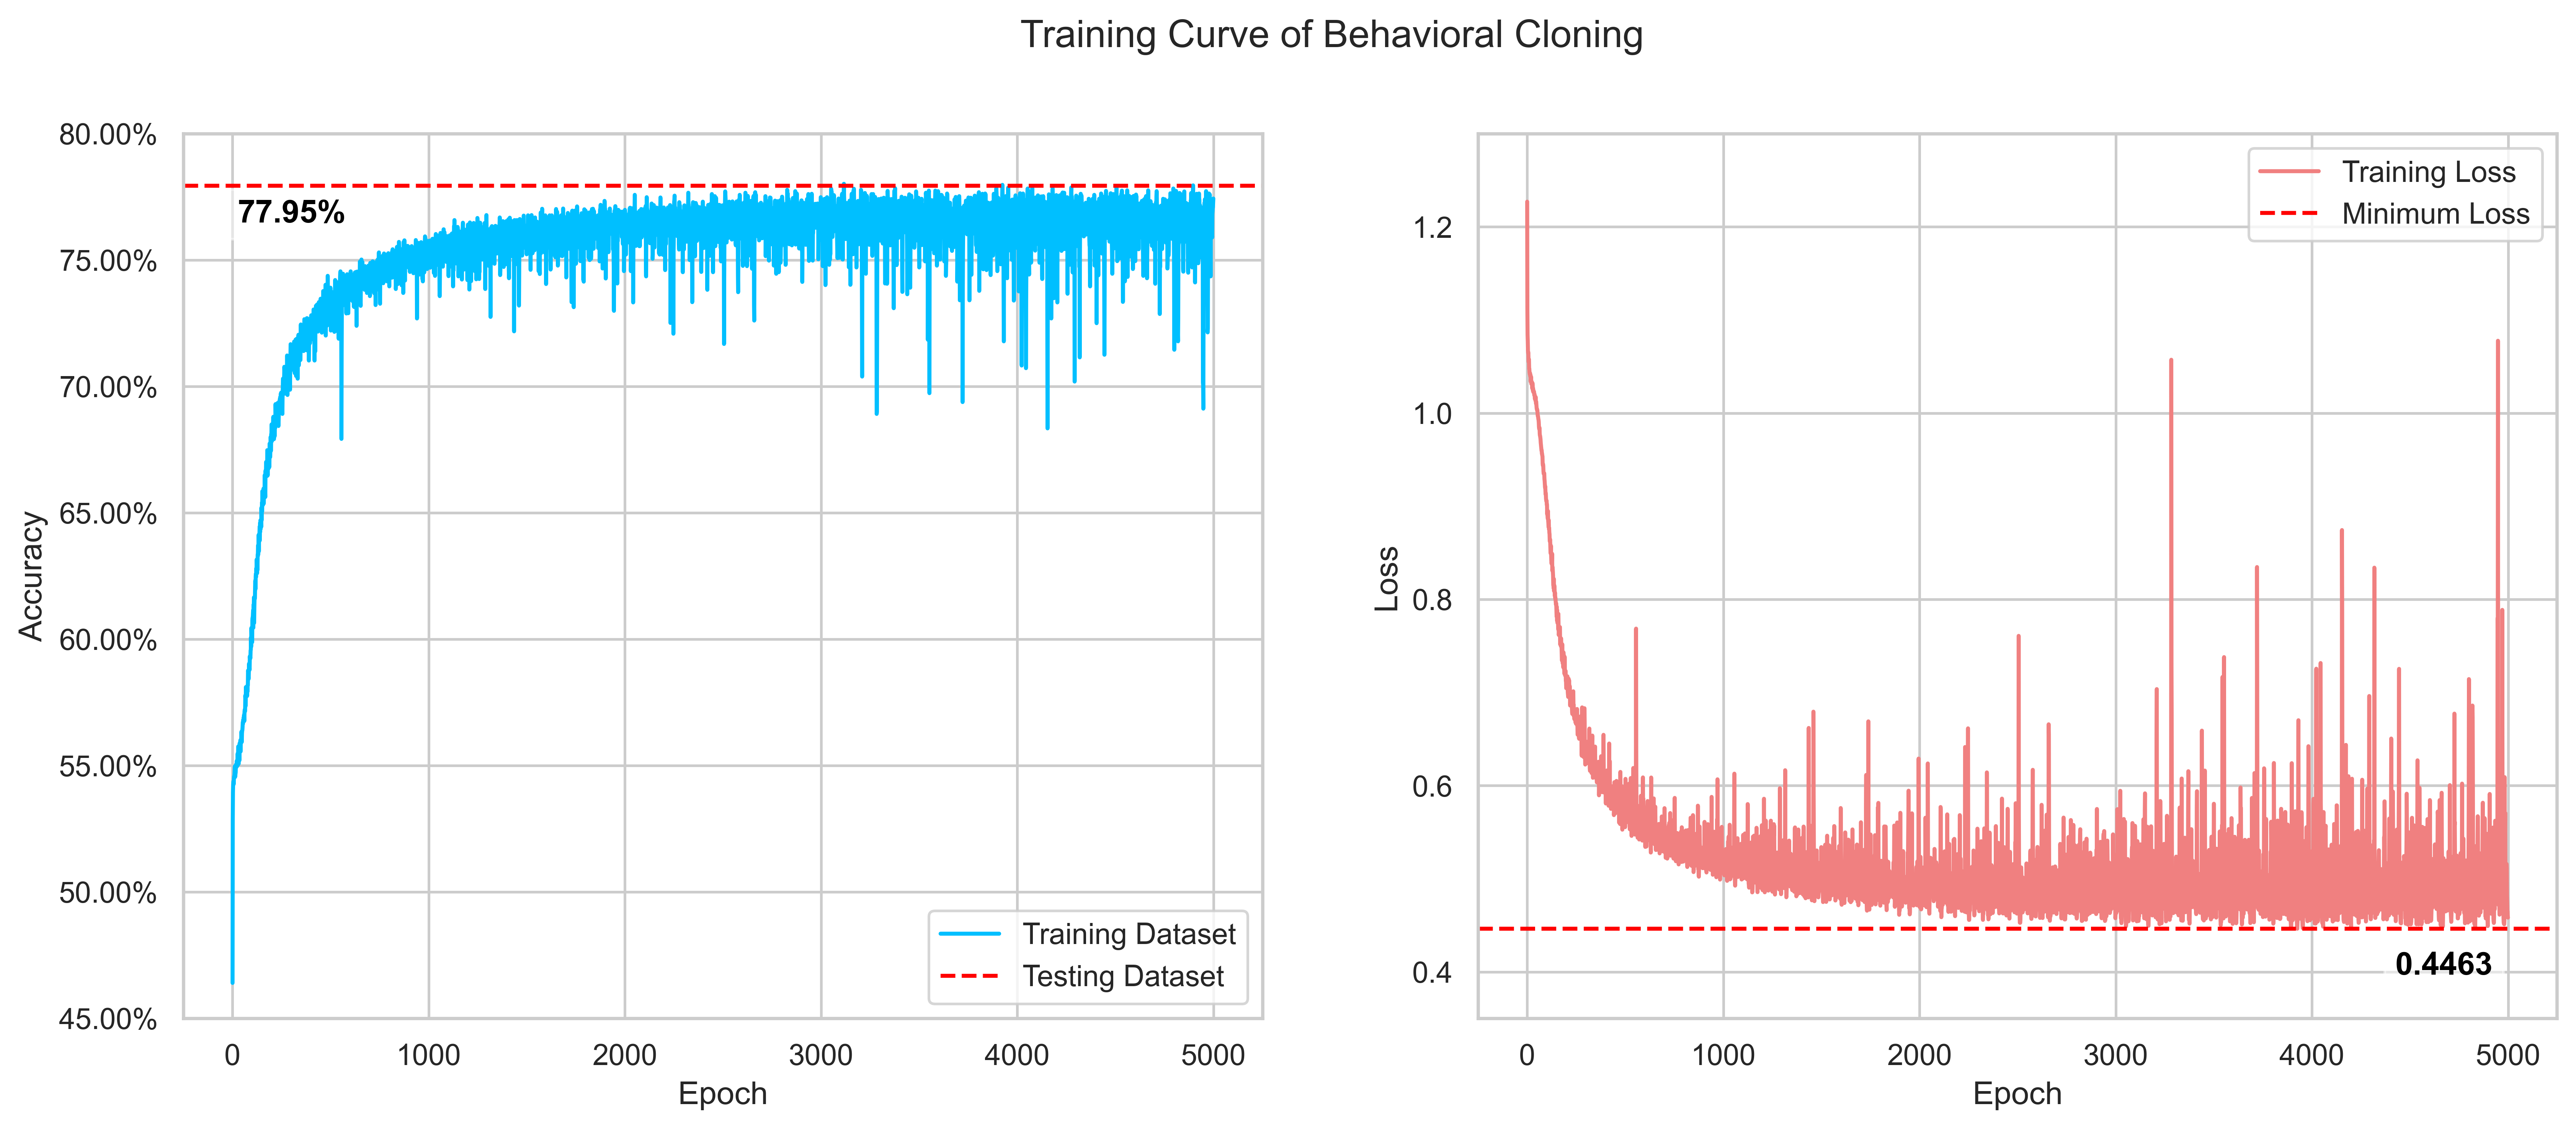

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

val_acc = 77.94653073962343

fig, axs = plt.subplots(ncols=2, figsize=(16, 6), dpi=500)

# Plot using Seaborn
sns.lineplot(x=np.arange(len(acc_list)), 
             y=acc_list, color='deepskyblue', linestyle='-', 
             label="Training Dataset", ax=axs[0])

axs[0].set(ylim=(45, 80))

vals = axs[0].get_yticks()
axs[0].set_yticklabels(['{:,.2%}'.format(x/100) for x in vals])

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].axhline(y=val_acc, c='red', linestyle='dashed', label="Testing Dataset")

axs[0].text(x=0.05, y=0.9, s="77.95%", fontsize=12, color='black', weight='bold', bbox=dict(facecolor='white', alpha=0.5), transform=axs[0].transAxes)
axs[0].legend()

sns.lineplot(x=np.arange(len(loss_list)), 
             y=loss_list, color='lightcoral',  linestyle='-', ax=axs[1], label="Training Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].axhline(y=np.min(loss_list), c='red', linestyle='dashed', label="Minimum Loss")
axs[1].set(ylim=(0.35, 1.3))
axs[1].text(x=0.85, y=0.05, s=str(np.min(loss_list))[:6], fontsize=12, color='black', weight='bold', bbox=dict(facecolor='white', alpha=0.5), transform=axs[1].transAxes)
axs[1].legend()

# Optional: Adding titles and labels
# plt.title('Training Curve of Behavioral Cloning')
fig.suptitle('Training Curve of Behavioral Cloning')
# fig.tight_layout()
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# Show the plot
plt.show()